Philippe Joly 2025-05-25

# ALBATROS Data Overview

This notebook is an overview of the structure of the ALBATROS data and the associated [albatros_analysis](https://github.com/ALBATROS-Experiment/albatros_analysis) repository
<br> This notebook uses a 1 hour of data rechannelized ($\times64$) to a frequency resolution of ~1 kHz. 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sys
import os
import pandas as pd
sys.path.append(os.path.expanduser('~'))

Telescope data fwom which the data used in this notebook stems from was recorded with:
- a 0-125 MHz frequency span;
- 2048 frequency channels; and
- a $250\times10^6$ samples/s samplig rate

## Data Structure 

In [2]:
with np.load("/project/s/sievers/mohanagr/xcorr_axion/xcorr_all_ant_4bit_1721361571_14336_64_15326_0_120.npz") as f:
    data = f['data']
    mask = f['mask']
    missing_fraction = f["missing_fraction"]
    chans = f['chans']

First analyze the name of the file: *xcorr_all_ant_4bit_1721361571_14336_64_15326_0_120.npz*

1. *4bit* : tells us that every values is strored as a 4bit complex number
2. *1721361571* : Subdirectory time stamp from wchich this exceprt of data was taken
3. *14336* : Length over which data is averaged
3. *64* : factor by wich it was rechannelized from the storage frequency resolution of 61 kHz
4. *15326* : The number of time steps (number of averaged rows)
5. *0_120* : Frequency channel indices (from 64-183)

In [3]:
print("Data Shape:", data.shape)
print("Mask Shape:", mask.shape)
print("Missing Fraction Shape:", missing_fraction.shape)
print("Channels Shape", chans.shape)

Data Shape: (2, 2, 7680, 15326)
Mask Shape: (2, 2, 7680, 15326)
Missing Fraction Shape: (1, 15326)
Channels Shape (7680,)


The mask is to account for values missing from the data acquisition. During data acquisition, missing measurements were recorded as zero values to conserve the time structure of the data. The mask allows the zero values to be omitted from analysis. The missing fraction array is the fraction of channels missing at a specific recording time. 

We can breakdown the shape of the data array: (2, 2, 7680, 15326)
1. (2, 2, x, x) : acccounts for the 4 polarization of the dual-polarization LWA antenna 
    1. (0, 0) : pol0 data auto-correlated with itself
    2. (1, 1) : pol1 data auto-correlated with itself
    3. (0, 1), (1, 0) : pol0 cross-correlated with pol1. Note that (0, 1) and (1, 0) are hermitian conjugate.
2. (x, x, 7680, x) : This is the number of frequency channels.
3. (x, x, x, 15326) : number of time steps

## Data Specifications 

In [4]:
df_record = 125e6/2048 # (Hz) frequency range / # of channels
df = df_record/64 # (Hz) / rechannelization factor
print(df_record*1e-3, "kHz Frequency resolution when recorded")
print(df*1e-3, "kHz Frequency resolution after x64 rechannelization")

61.03515625 kHz Frequency resolution when recorded
0.95367431640625 kHz Frequency resolution after x64 rechannelization


In [5]:
sr = 250e6 # sampling rate
recording_step_length = 1/sr # (s)
N = 14336 # samples/average
avg_window_length = N*recording_step_length # (s) 
print("Time step of recording:", recording_step_length*1e9, "ns")
print("Transform window length:", avg_window_length*1e6, "mu s")
print("Raw recording frequency:", 1/avg_window_length*1e-3, "kHz")

Time step of recording: 4.0 ns
Transform window length: 57.34400000000001 mu s
Raw recording frequency: 17.43861607142857 kHz


Notice that the raw frequency resolution ~17 kHz is better than the data frquency resolution. This is because the transform outputs were aggregates/averaged to get channels spaced ~61 kHz apart. 

In [6]:
total_time = N/df_record*15326 # (s)
print(total_time/(60**2), "hour of total obeservation time")

0.999940714951111 hour of total obeservation time


##  Data Visualisation

In [7]:
spectra = np.ma.MaskedArray(data=data, mask=mask)
freqs = chans*df # (Hz)
times = N/df_record*np.arange(15326)

In [8]:
avg_spectrum = np.mean(np.abs(spectra[0, 0,:,:]), axis=1)

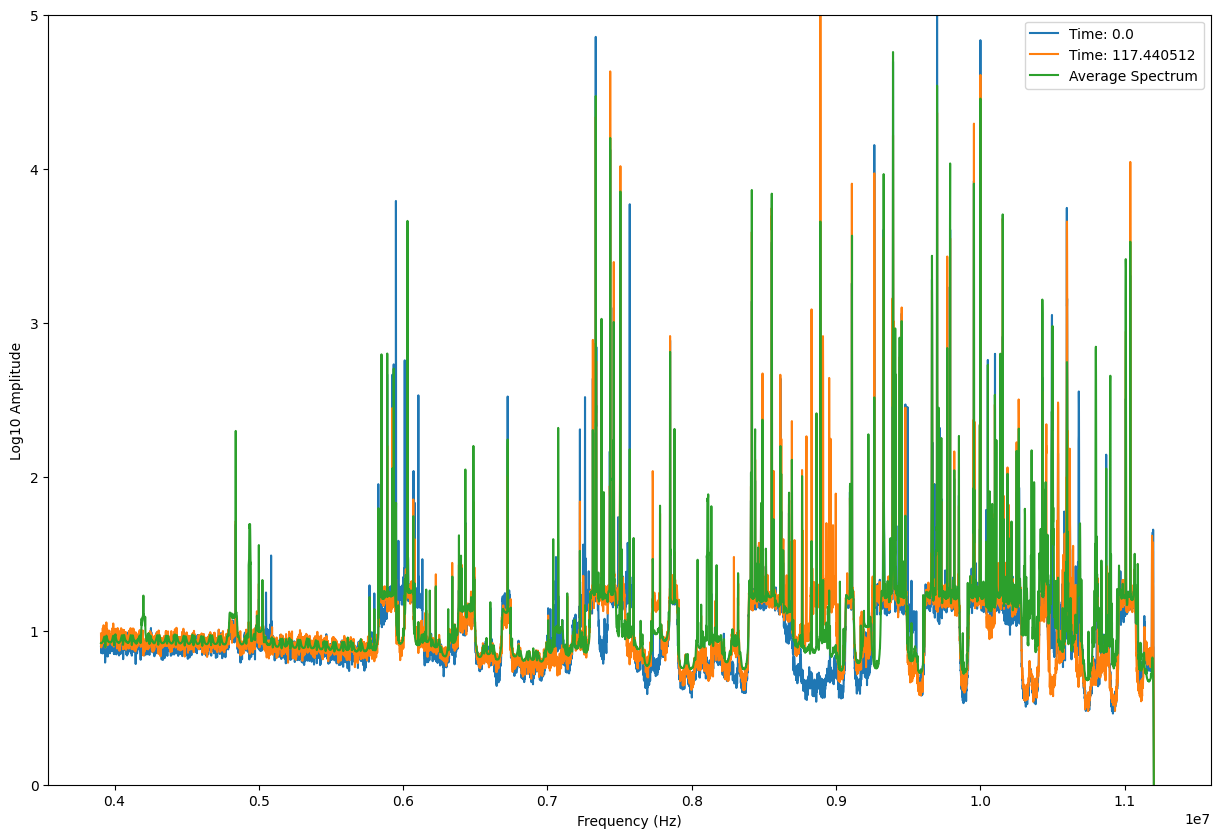

In [9]:
plt.figure(figsize=(15,10))
for i in range(2):    
    plt.plot(freqs, np.log10(np.abs(spectra[0,0,:,i*500])), label=f"Time: {times[i*500]}")

plt.plot(freqs, np.log10(avg_spectrum), label="Average Spectrum")

# i = 6
# print((3.904e6+i*61e3)/1e6)
# plt.xlim(3.904e6+i*61e3,3.904e6+(i+1)*61e3)
# plt.ylim(0.8,1.2)

plt.ylim(0,5)

plt.xlabel('Frequency (Hz)')   
plt.ylabel('Log10 Amplitude')
plt.legend()

plt.show()

This plot illustrates data amplitude across frequencies at particular times.

/tmp/ipykernel_177041/1343418243.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.plot(times, np.log10(np.abs(spectra[0,0,(i+1)*100, :])))


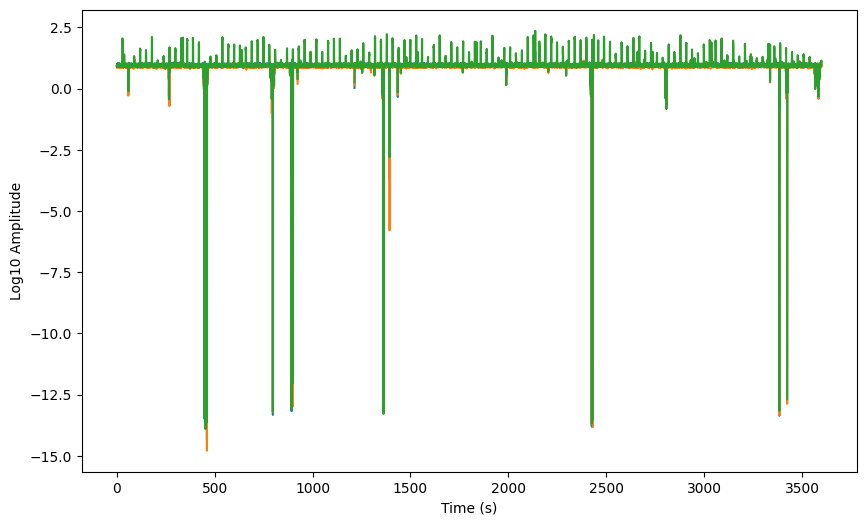

In [10]:
plt.figure(figsize=(10,6))
for i in range(3):    
    plt.plot(times, np.log10(np.abs(spectra[0,0,(i+1)*100, :])))

plt.xlabel('Time (s)')   
plt.ylabel('Log10 Amplitude')

plt.show()

This plot illustrates the data's amplitude at given frequencies across time.

In [11]:
# Data Histogram
total_band = np.log10(np.abs(spectra[0, 0, :, :].flatten()))
total_band = np.nan_to_num(total_band, nan=0.0, posinf=0.0, neginf=0)

/tmp/ipykernel_177041/481190117.py:2: RuntimeWarning: divide by zero encountered in log10
  total_band = np.log10(np.abs(spectra[0, 0, :, :].flatten()))


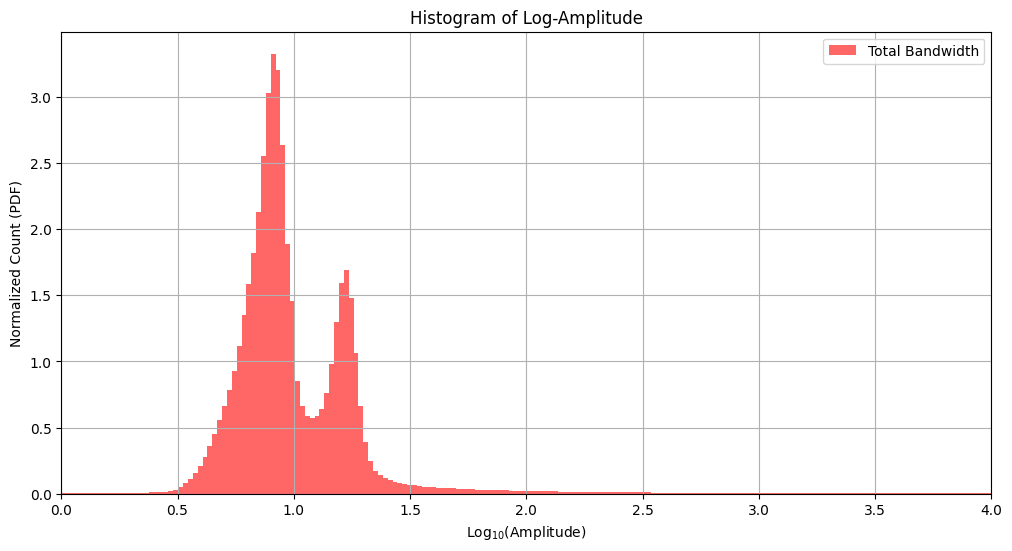

In [12]:
plt.figure(figsize=(12,6))

plt.hist(total_band, bins=1000, alpha=0.6, label='Total Bandwidth', color='r', density=True)

plt.xlabel("Log$_{10}$(Amplitude)")
plt.ylabel("Normalized Count (PDF)")
plt.title("Histogram of Log-Amplitude")
plt.legend()
plt.xlim(0,4)
plt.grid(True)
plt.show()

We can clearly see that the data does not seem Gaussian (which would be expected without any external interference). The second peak and the long tail are caused by RFI noise.

/tmp/ipykernel_177041/1149746350.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(spectra[0, 0, 5000:6000, :].T)), aspect='auto', vmin=0, vmax=3, interpolation='none')


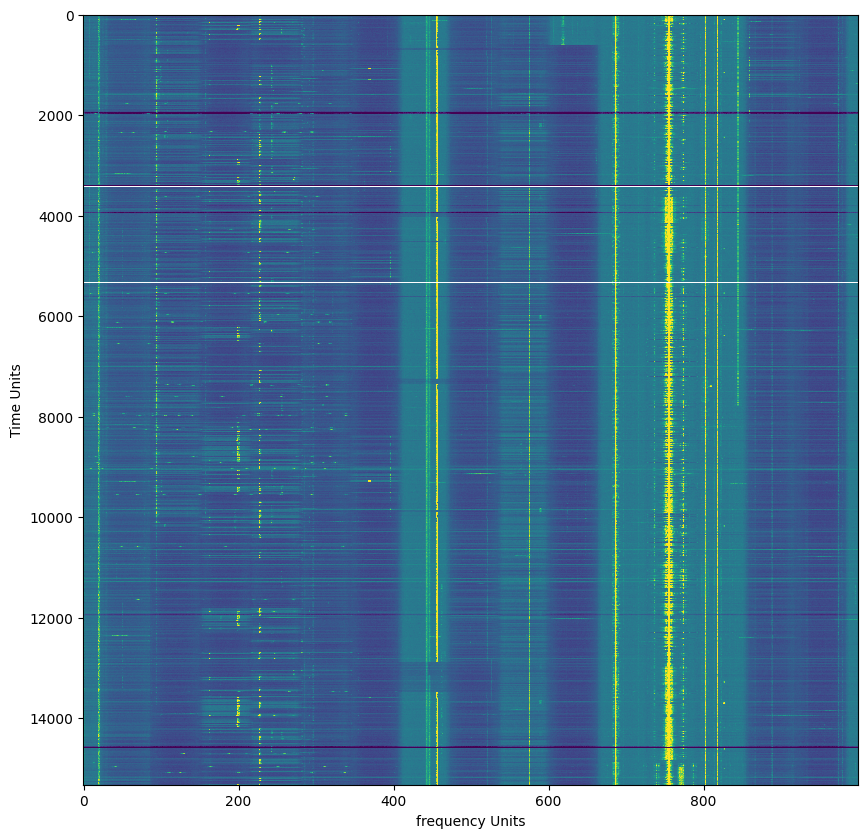

In [13]:
# Waterfall plot
plt.figure(figsize=(10,10))
plt.imshow(np.log10(np.abs(spectra[0, 0, 5000:6000, :].T)), aspect='auto', vmin=0, vmax=3, interpolation='none')
plt.ylabel("Time Units")
plt.xlabel("frequency Units")
plt.show()

This waterfall plot gives a 2D view of the data. We can clearly see birght frequency lines across time. Also note that the grey time lines across frequency are missing data.

## Frequency Line Visualisation

From the above waterfall plot, we can qualitatively pick a busy band 5750-5774 Frequency units and a calmer one 5475-5500. We can analyze their respective distributions.

/tmp/ipykernel_177041/4227401872.py:1: RuntimeWarning: divide by zero encountered in log10
  busy_band = np.log10(np.abs(spectra[0, 0, 5750:5775, :].flatten()))
/tmp/ipykernel_177041/4227401872.py:2: RuntimeWarning: divide by zero encountered in log10
  calm_band = np.log10(np.abs(spectra[0, 0, 5475:5500, :].flatten()))


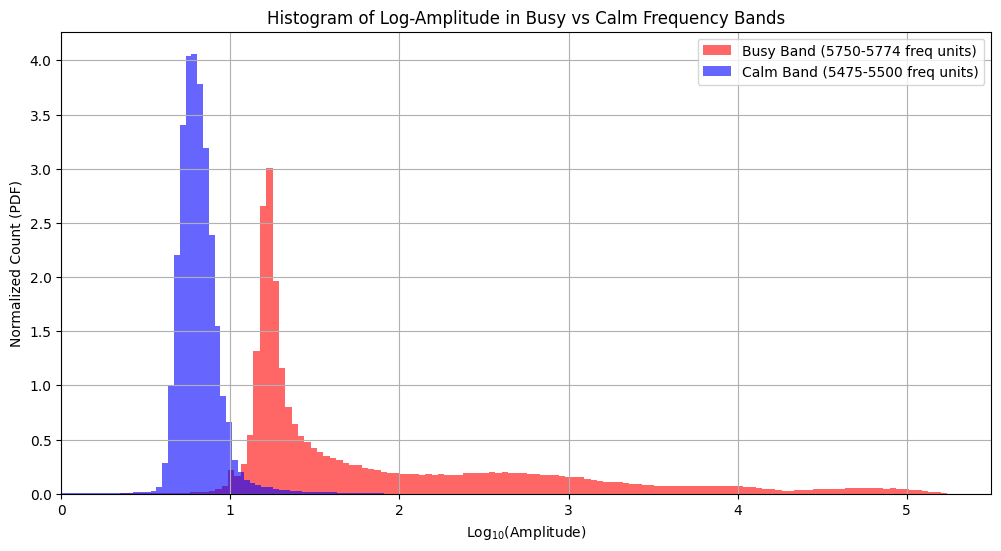

In [14]:
busy_band = np.log10(np.abs(spectra[0, 0, 5750:5775, :].flatten()))
calm_band = np.log10(np.abs(spectra[0, 0, 5475:5500, :].flatten()))

busy_band = np.nan_to_num(busy_band, nan=0.0, posinf=0.0, neginf=0)
calm_band = np.nan_to_num(calm_band, nan=0.0, posinf=0.0, neginf=0.0)

plt.figure(figsize=(12,6))

plt.hist(busy_band, bins=500, alpha=0.6, label='Busy Band (5750-5774 freq units)', color='r', density=True)
plt.hist(calm_band, bins=500, alpha=0.6, label='Calm Band (5475-5500 freq units)', color='b', density=True)

plt.xlabel("Log$_{10}$(Amplitude)")
plt.ylabel("Normalized Count (PDF)")
plt.title("Histogram of Log-Amplitude in Busy vs Calm Frequency Bands")
plt.legend()
plt.xlim(0,5.5)
plt.grid(True)
plt.show()

Notice that the distribution of the calm band appears gaussian like whereas the busy band has a long tail. The calm band is also appears much tighter than its busy counterpart

## Clean Band Determination

Several methods can be used to determine which bandwidth are good for analysis and which are contaminated by RFI.
1. Median filtering
2. Median Absolute Deviation
3. Z-score
4. Spectral Kurtosis
5. Time Variability

### Median Filtering
This is the most simple method. It involves comparing each value to the median over a sliding window centered around it. If the difference between the 2 is bigger than some threshold, the band is omitted.

In [15]:
avg_spectrum = np.mean(np.abs(spectra[0, 0,:,:]), axis=1)

In [16]:
from scipy.signal import medfilt
med_thresh = 0.5 # (dB)
med_ks = 101 # ~100 kHz

clean_baseline = medfilt(np.log10(avg_spectrum), kernel_size=med_ks) # ~100 kHz kernel
med_mask = np.log10(avg_spectrum) > (clean_baseline + med_thresh)

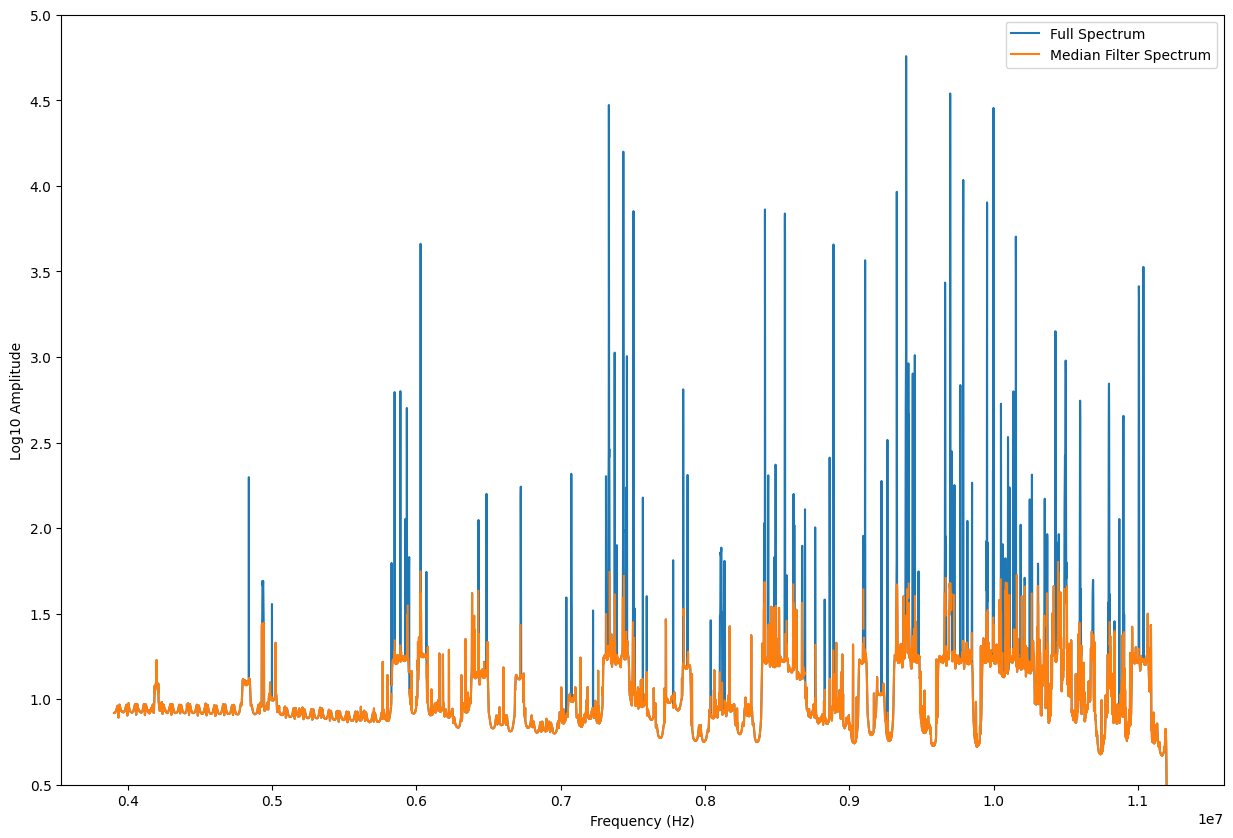

In [17]:
plt.figure(figsize=(15,10))

plt.plot(freqs, np.log10(avg_spectrum), label="Full Spectrum")
plt.plot(freqs, np.ma.MaskedArray(data=np.log10(avg_spectrum), mask=med_mask), label="Median Filter Spectrum")

plt.xlabel('Frequency (Hz)')   
plt.ylabel('Log10 Amplitude')
plt.legend()
plt.ylim(0.5,5)

plt.show()

### Median Absolute Deviation (MAD)

In [65]:
# from scipy.stats import median_abs_deviation
# from numpy.lib.stride_tricks import as_strided

# mad_ws = 101
# mad_thresh = 3

# psd = np.abs(spectra[0,0, :, :])
# pad = mad_ws // 2

# # Pad time dimension
# psd_padded = np.pad(psd, ((0, 0), (pad, pad)), mode='reflect')  

# shape = (psd.shape[0], psd.shape[1], mad_ws)
# strides = (psd_padded.strides[0], psd_padded.strides[1], psd_padded.strides[1])
# windows = as_strided(psd_padded, shape=shape, strides=strides) 

# # Compute rolling median and MAD 
# rolling_median = np.median(windows, axis=2)                     
# rolling_mad = median_abs_deviation(windows, axis=2, scale='normal')  

# deviation = np.abs(psd - rolling_median)

# mad_mask = deviation > (mad_thresh * rolling_mad)
# mad_fraction = mad_mask.mean(axis=1)

MemoryError: Unable to allocate 44.3 GiB for an array with shape (7680, 15326, 101) and data type float32

In [ ]:
# plt.figure(figsize=(12,6))
# plt.plot(freqs, mad_fraction)
# plt.xlabel("Frequency (Hz)")
# plt.ylabel("RFI Fraction")
# plt.title("RFI Fraction per Frequency Bin (Windowed MAD)")
# plt.grid(True)
# plt.show()

Too long and not enough memory. Would be to do on MIST (GPU).

### Z-Score
Z-score peak detection is a statistical method for identifying peaks in time-series data by measuring how many standard deviations a data point is from a rolling mean.

In [42]:
from scipy.stats import zscore

z_ws = 101

z_scores = pd.Series(avg_spectrum).rolling(z_ws).apply(lambda x: zscore(x)[-1])
z_mask = z_scores > 0.01

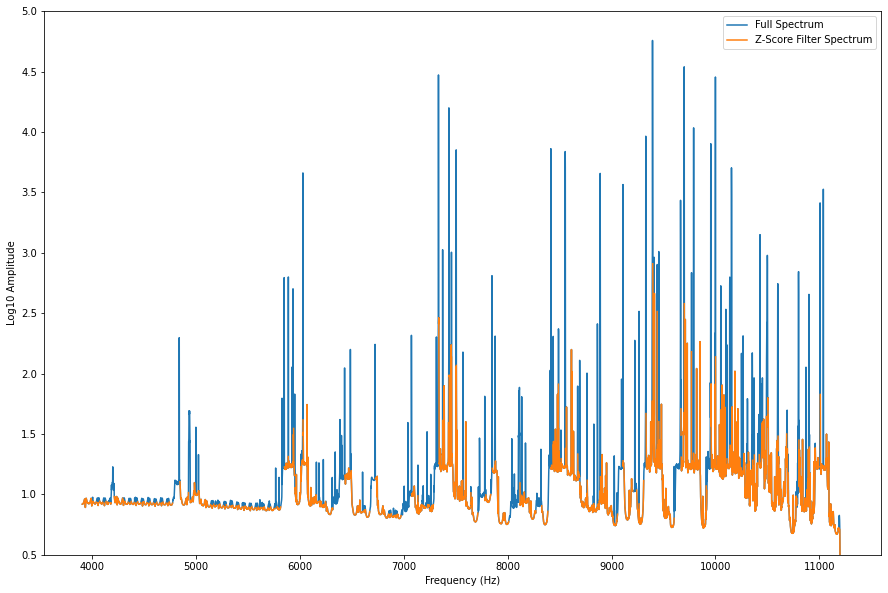

In [43]:
plt.figure(figsize=(15,10))

plt.plot(freqs, np.log10(avg_spectrum), label="Full Spectrum")
plt.plot(freqs, np.ma.MaskedArray(data=np.log10(avg_spectrum), mask=z_mask), label="Z-Score Filter Spectrum")

plt.xlabel('Frequency (Hz)')   
plt.ylabel('Log10 Amplitude')
plt.legend()
plt.ylim(0.5,5)

plt.show()

### Spectral Kurtosis
Identifies non-Gaussian signals like RFI in time-averaged spectra.

In [66]:
from scipy.stats import kurtosis

sk = kurtosis(np.abs(spectra[0,0,:,:]), axis=1, fisher=False)

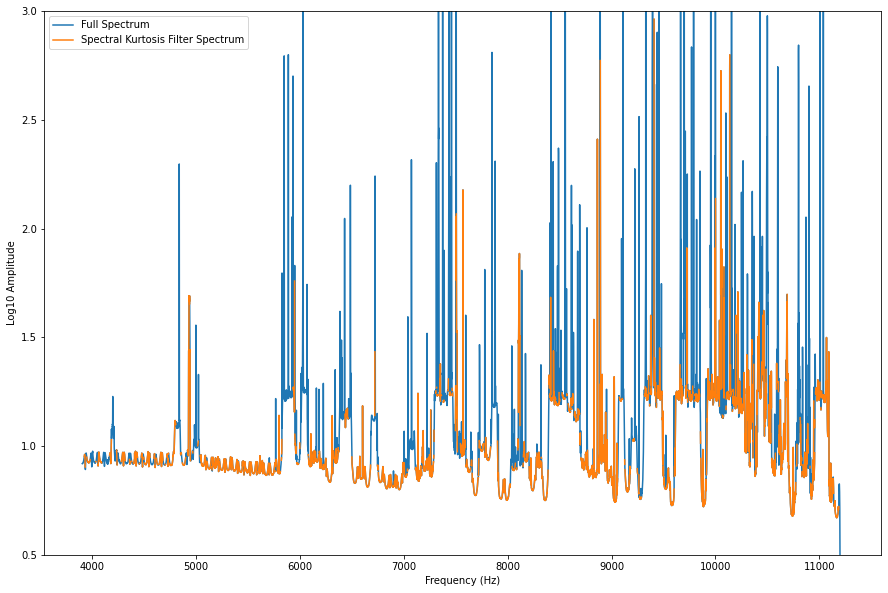

In [87]:
sk_mask = np.log10(sk) < 2
plt.figure(figsize=(15,10))

plt.plot(freqs, np.log10(avg_spectrum), label="Full Spectrum")
# plt.plot(freqs, np.log10(sk), label="Kurtosis Spectrum")
plt.plot(freqs, np.ma.MaskedArray(data=np.log10(avg_spectrum), mask=sk_mask), label="Spectral Kurtosis Filter Spectrum")

plt.xlabel('Frequency (Hz)')   
plt.ylabel('Log10 Amplitude')
plt.legend()
plt.ylim(0.5,3)
# plt.xlim(4000,5000)

plt.show()

### Time Variability 
Clean channels are expected to have low power and low variance.

In [88]:
std_dev = np.std(psd, axis=1)

(-1.0, 100.0)

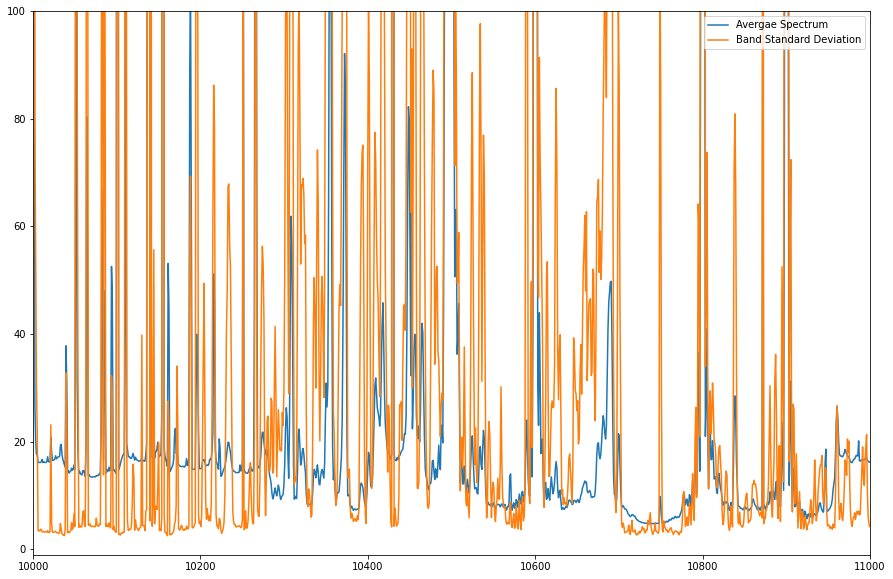

In [97]:
plt.figure(figsize=(15,10))
plt.plot(freqs, avg_spectrum, label="Average Spectrum")
plt.plot(freqs, std_dev, label="Band Standard Deviation")
plt.legend()
plt.xlim(10000,11000)
plt.ylim(-1, 100)

In [104]:
power_thresh = 20
time_var_thresh = 20
time_var_mask = (std_dev > time_var_thresh) | (avg_spectrum > power_thresh)

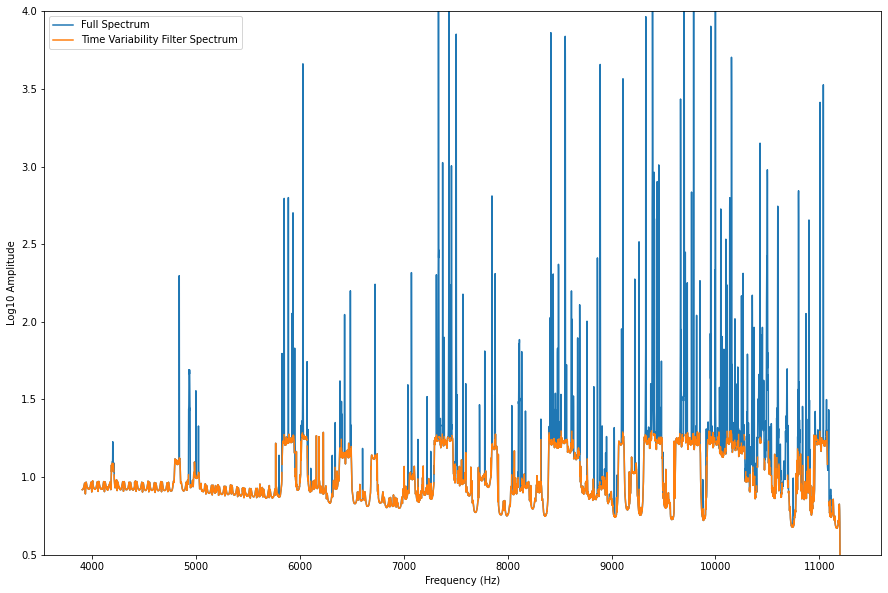

In [106]:
plt.figure(figsize=(15,10))

plt.plot(freqs, np.log10(avg_spectrum), label="Full Spectrum")
plt.plot(freqs, np.ma.MaskedArray(data=np.log10(avg_spectrum), mask=time_var_mask), label="Time Variability Filter Spectrum")

plt.xlabel('Frequency (Hz)')   
plt.ylabel('Log10 Amplitude')
plt.legend()
plt.ylim(0.5,4)
# plt.xlim(4000,5000)

plt.show()